In [1]:
using PyCall
using PyPlot
using Statistics

yf = pyimport("yfinance")
np = pyimport("numpy")

include("OptimPortfolio.jl")

Efficient_frontier (generic function with 3 methods)

# Data donwload and basic analysis 

In [2]:
start = "2013-01-01"
finish = "2017-01-01" 

start_test = "2017-01-01"
finish_test  ="2018-01-01"

assets = ["MSFT", "AAPL", "TSLA", "GOOG", "META", "AMZN"] #"^GSPC"

df = yf.download(assets, start, finish, progress=false)

df_test = yf.download(assets, start_test, finish_test, progress=false)

market = yf.download("^GSPC", start, finish, progress=false)

market_test = yf.download("^GSPC", start_test, finish_test, progress=false)

df_log_ret = (df["Adj Close"] / df["Adj Close"].shift(1)).apply(np.log)
df_test_log_ret = (df_test["Adj Close"] / df_test["Adj Close"].shift(1)).apply(np.log)

market_log_ret = (market["Adj Close"] / market["Adj Close"].shift(1)).apply(np.log)
market_test_log_ret = (market_test["Adj Close"] / market_test["Adj Close"].shift(1)).apply(np.log);

## Asset analysis

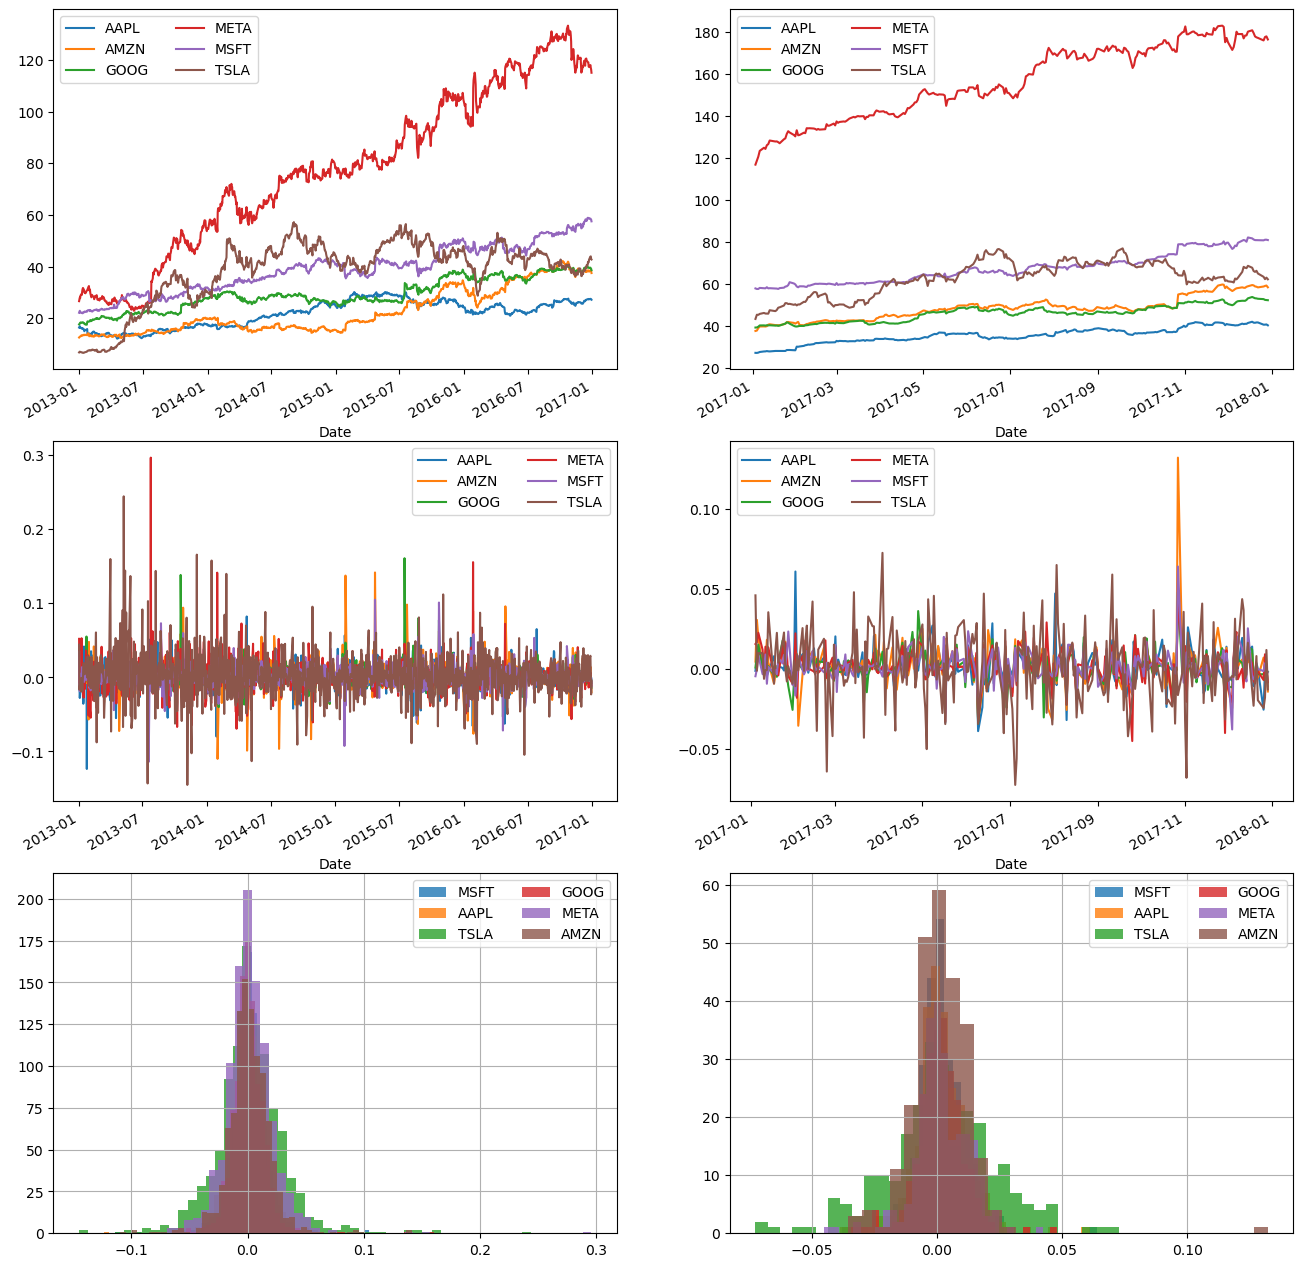

PyObject <matplotlib.legend.Legend object at 0x7f2e0faa7ac0>

In [3]:
fig, ax = plt.subplot_mosaic("""AB
    CD
    EF""", figsize=(8*2, 6*3))

# Stock prices
df["Adj Close"].plot(ax=ax["A"])

ax["A"].legend(ncol=2)

df_test["Adj Close"].plot(ax=ax["B"])

ax["B"].legend(ncol=2)

#Returns
df["Adj Close"].pct_change().plot(ax=ax["C"])
#df_log_ret.plot(ax=ax["C"])

ax["C"].legend(ncol=2)

df_test["Adj Close"].pct_change().plot(ax=ax["D"])
#df_test_log_ret.plot(ax=ax["D"])

ax["D"].legend(ncol=2)

#Histogram of returns
for asset in assets
    df["Adj Close"][asset].pct_change().hist(ax=ax["E"], bins=50, alpha=0.8, label=asset)
    #df_log_ret[asset].hist(ax=ax["E"], bins=50, alpha=0.8, label=asset)
end

ax["E"].legend(ncol=2)

for asset in assets
    df_test["Adj Close"][asset].pct_change().hist(ax=ax["F"], bins=30, alpha=0.8, label=asset)
    #df_test_log_ret[asset].hist(ax=ax["F"], bins=30, alpha=0.8, label=asset)
end

ax["F"].legend(ncol=2)

## Market analysis 

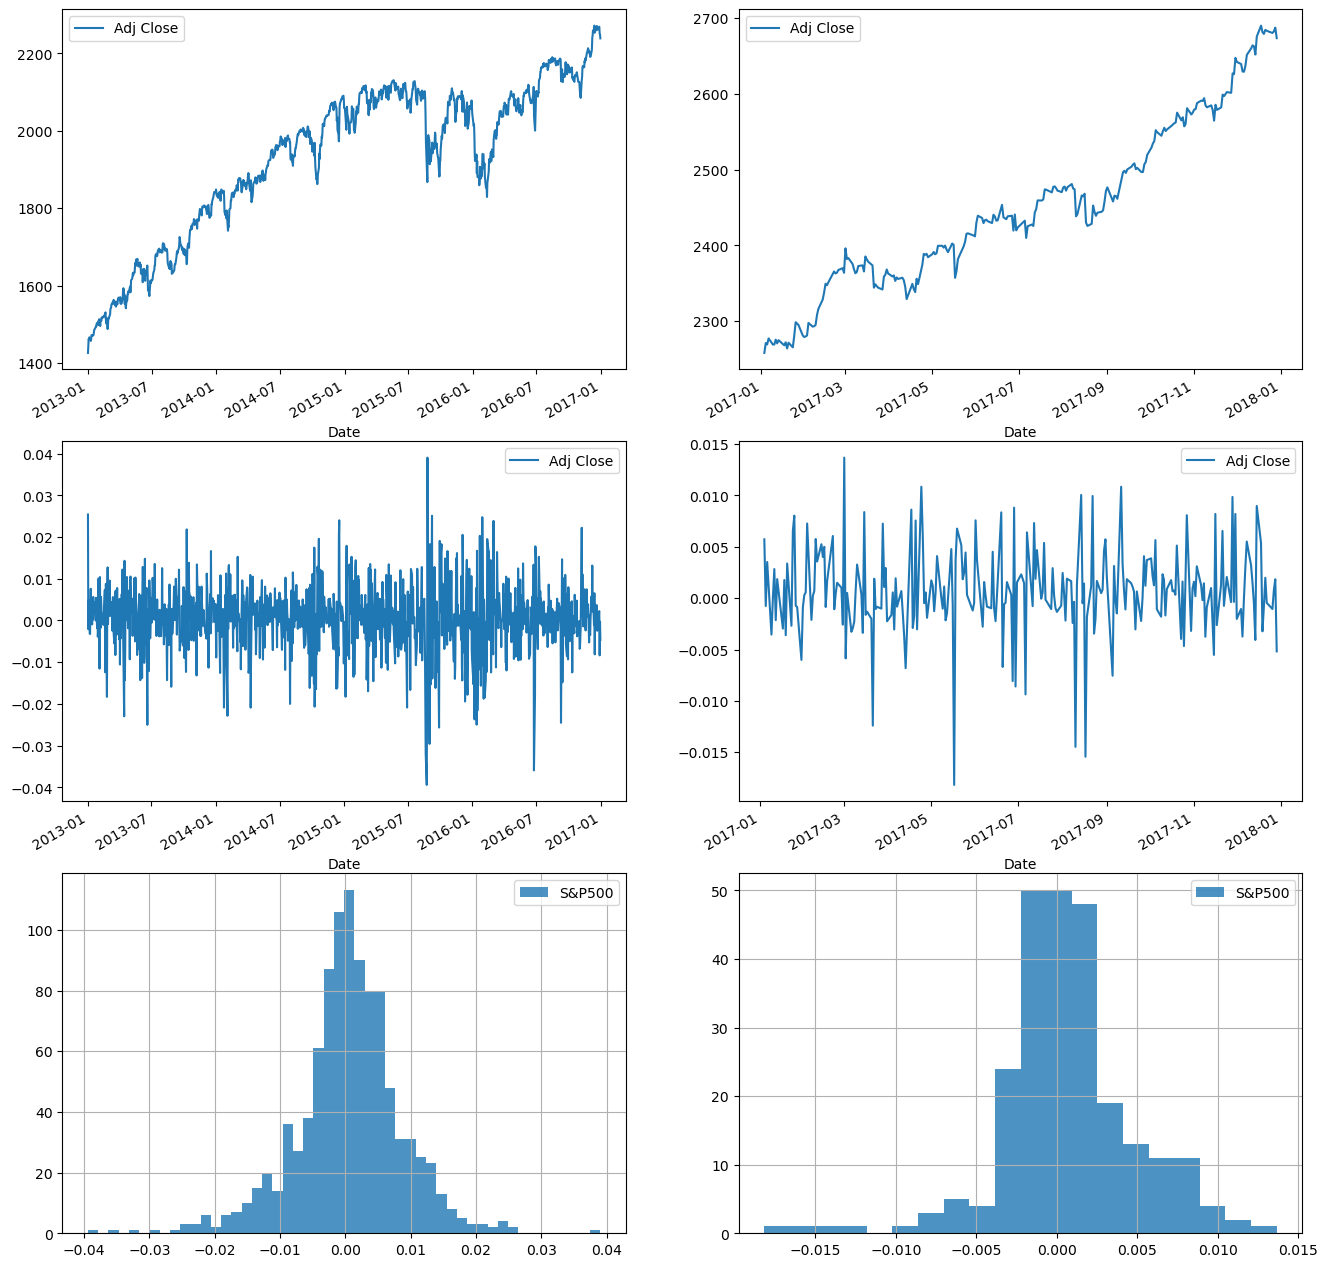

PyObject <matplotlib.legend.Legend object at 0x7f2e0d868b20>

In [4]:
fig, ax = plt.subplot_mosaic("""AB
    CD
    EF""", figsize=(8*2, 6*3))

# Stock prices
market["Adj Close"].plot(ax=ax["A"])

ax["A"].legend(ncol=2)

market_test["Adj Close"].plot(ax=ax["B"])

ax["B"].legend(ncol=2)

#Returns
market["Adj Close"].pct_change().plot(ax=ax["C"])
#market_log_ret.plot(ax=ax["C"])

ax["C"].legend(ncol=2)

market_test["Adj Close"].pct_change().plot(ax=ax["D"])
#market_test_log_ret.plot(ax=ax["D"])

ax["D"].legend(ncol=2)

#Histogram of returns
market["Adj Close"].pct_change().hist(ax=ax["E"], bins=50, alpha=0.8, label="S&P500")
#market_log_ret.hist(ax=ax["E"], bins=50, alpha=0.8, label="S&P500")

ax["E"].legend(ncol=2)

market_test["Adj Close"].pct_change().hist(ax=ax["F"], bins=20, alpha=0.8, label="S&P500")
#market_test_log_ret.hist(ax=ax["F"], bins=20, alpha=0.8, label="S&P500")

ax["F"].legend(ncol=2)

# Resample data to 1-month frequency

In [5]:
freq = "1M"

df = df.resample(freq).mean()

df_test = df_test.resample(freq).mean()

market = market.resample(freq).mean()

market_test = market_test.resample(freq).mean()

df_log_ret = (df["Adj Close"] / df["Adj Close"].shift(1)).apply(np.log)
df_test_log_ret = (df_test["Adj Close"] / df_test["Adj Close"].shift(1)).apply(np.log)

market_log_ret = (market["Adj Close"] / market["Adj Close"].shift(1)).apply(np.log)
market_test_log_ret = (market_test["Adj Close"] / market_test["Adj Close"].shift(1)).apply(np.log);

# Mean-Variance portfolio optimization 

In [45]:
μ = df["Adj Close"].pct_change().mean().values
Σ = df["Adj Close"].pct_change().cov().values

μ_log = df_log_ret.mean().values
Σ_log = df_log_ret.cov().values

portfolio = Portfolio(µ, Σ)
portfolio_log = Portfolio(μ_log, Σ_log);

### Fixed returns 

In [48]:
target_return = 0.03

w_opt = MPT_fixed_return(portfolio, target_return)

return_portfolio = sum(w_opt.*μ)
risk_portfolio = sqrt(transpose(w_opt)*portfolio.Σ*w_opt)

return_market = market["Adj Close"].pct_change().mean()
risk_market = sqrt(market["Adj Close"].pct_change().var())

println("Expected Returns Portfolio: ", return_portfolio)
println("Risk Portfolio: ", risk_portfolio)
#println("Weights:", w_opt)

println("\nExpected Return Market: ", return_market)
println("Risk Market: ", risk_market)

println("\nPortfolio-market return ratio: ", return_portfolio/return_market)
println("Portfolio-market risk ratio: ", risk_portfolio/risk_market)

Expected Returns Portfolio: 0.029999944217011465
Risk Portfolio: 0.04609814382234935

Expected Return Market: 0.009800984240852365
Risk Market: 0.0242919579481697

Portfolio-market return ratio: 3.060911381937132
Portfolio-market risk ratio: 1.897670987275139


### Fixed risk 

In [50]:
target_risk = 0.035

w_opt = MPT_fixed_risk(portfolio, target_risk)

return_portfolio = sum(w_opt.*μ)
risk_portfolio = sqrt(transpose(w_opt)*portfolio.Σ*w_opt)

return_market = market["Adj Close"].pct_change().mean()
risk_market = sqrt(market["Adj Close"].pct_change().var())

println("Expected Returns Portfolio: ", return_portfolio)
println("Risk Portfolio: ", risk_portfolio)
#println("Weights:", w_opt)

println("\nExpected Return Market: ", return_market)
println("Risk Market: ", risk_market)

println("\nPortfolio-market return ratio: ", return_portfolio/return_market)
println("Portfolio-market risk ratio: ", risk_portfolio/risk_market)

Expected Returns Portfolio: 0.024294161401150458
Risk Portfolio: 0.03499558306147869

Expected Return Market: 0.009800984240852365
Risk Market: 0.0242919579481697

Portfolio-market return ratio: 2.4787471139773674
Portfolio-market risk ratio: 1.4406242237100308


# Efficient frontier 

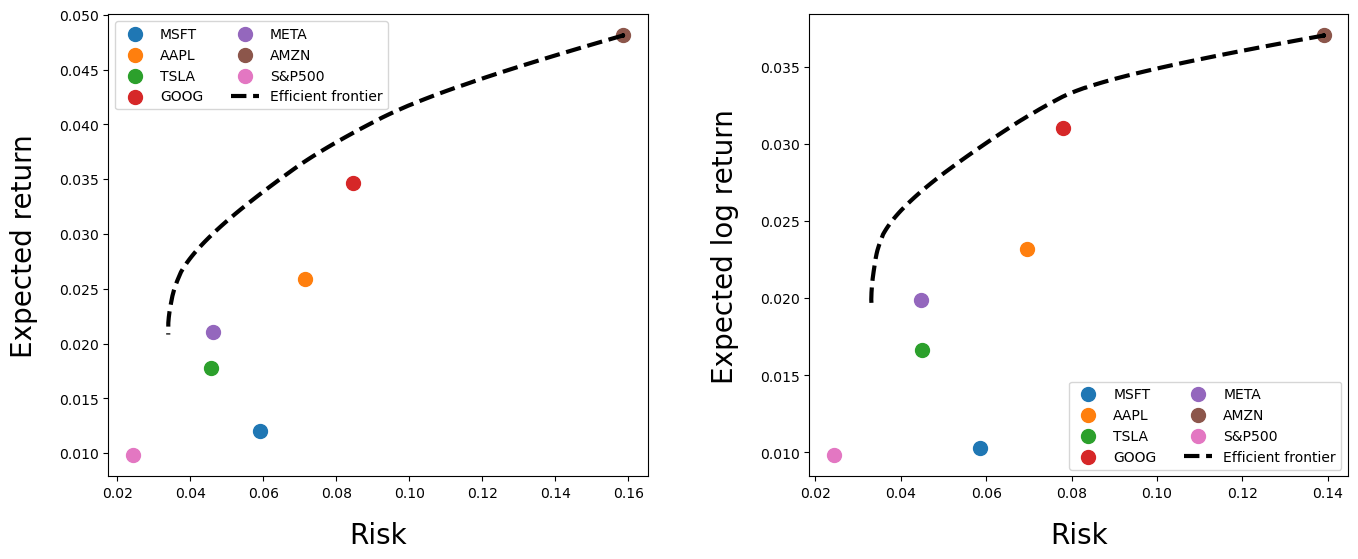

In [51]:
MeanVar, weights = Efficient_frontier(portfolio, 100);

MeanVar_log, weights_log = Efficient_frontier(portfolio_log, 100);

risks = sqrt.(diag(portfolio.Σ))
risks_log = sqrt.(diag(portfolio_log.Σ))

plt.figure(figsize=(8*2, 6))

plt.subplot(1, 2, 1)

for i in 1:length(portfolio.μ)

    plt.scatter(risks[i], portfolio.μ[i], s=100, label=assets[i])
    
end

plt.scatter(risk_market, return_market, s=100, label="S&P500")

plt.plot(sqrt.(MeanVar[:, 2]), MeanVar[:, 1], color="k", lw=3, ls="--", label="Efficient frontier")

plt.ylabel("Expected return", fontsize=20, labelpad=15)
plt.xlabel("Risk", fontsize=20, labelpad=15)

plt.legend(ncol=2)

plt.subplot(1, 2, 2)

for i in 1:length(portfolio.μ)

    plt.scatter(risks_log[i], portfolio_log.μ[i], s=100, label=assets[i])
    
end

plt.scatter(risk_market, return_market, s=100, label="S&P500")

plt.plot(sqrt.(MeanVar_log[:, 2]), MeanVar_log[:, 1], color="k", lw=3, ls="--", label="Efficient frontier")

plt.ylabel("Expected log return", fontsize=20, labelpad=15)
plt.xlabel("Risk", fontsize=20, labelpad=15)

plt.legend(ncol=2)

plt.subplots_adjust(wspace=0.3)

# Portfolio testing 

## Obtain yields after 1-month investment period for all posible investments next year

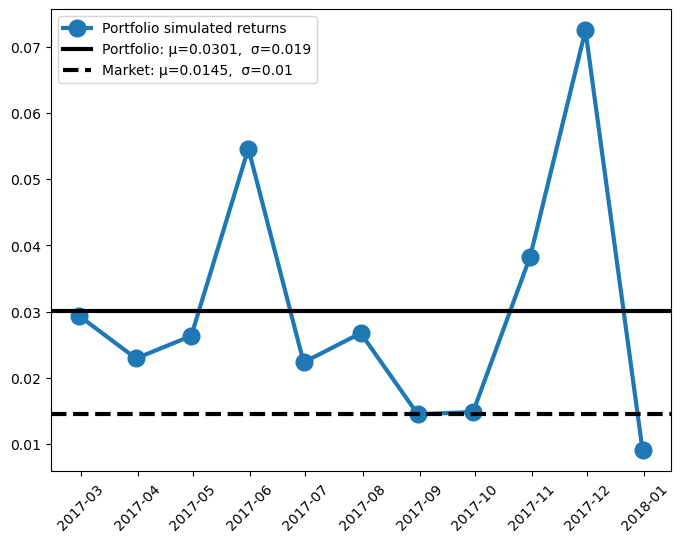

PyObject <matplotlib.legend.Legend object at 0x7f2e0c0c99a0>

In [57]:
#Test in "future" data
df_test_returns = df_test["Adj Close"].pct_change()

target_return = 0.025

#Optimize in past data
w_opt = MPT_fixed_return(portfolio, target_return)

returns = df_test_returns.values[2:length(df_test_returns), :] * w_opt
    
risk = round(sqrt(var(returns)), digits=3)

dates = [df_test["Adj Close"].index[i] for i in 2: length(df_test)]

mean_return = round(mean(returns), digits=4)
return_market = round(market_test["Adj Close"].pct_change().mean(), digits=4)
risk_market = round(sqrt(market_test["Adj Close"].pct_change().var()), digits=3)

plt.figure(figsize=(8,6))

plt.plot(dates, returns, lw=3, marker="o", ms=12, label="Portfolio simulated returns")

plt.axhline(mean_return, color="k", lw=3, label="Portfolio: μ=$mean_return,  σ=$risk")
plt.axhline(return_market, color="k", lw=3, ls="--", label="Market: μ=$return_market,  σ=$risk_market")

plt.xticks(rotation=45)

plt.legend()

  0.022032 seconds (113.88 k allocations: 5.956 MiB)


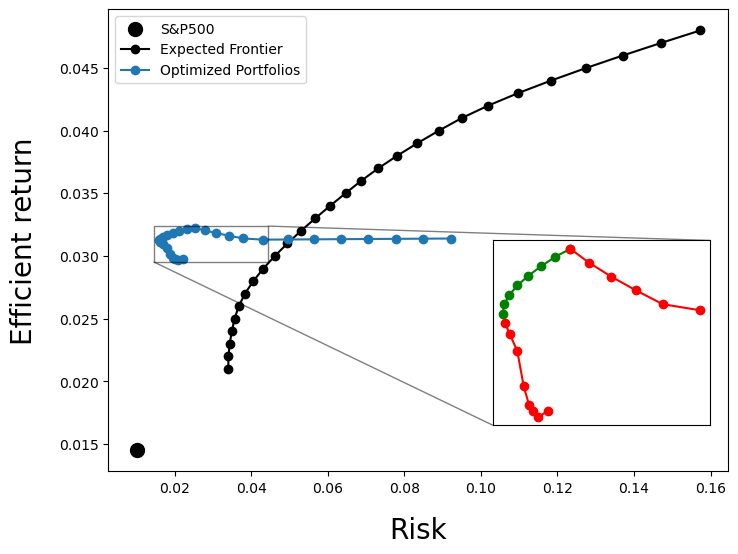

(PyObject <matplotlib.patches.Rectangle object at 0x7f2dd31945e0>, (PyObject <matplotlib.patches.ConnectionPatch object at 0x7f2dd315e160>, PyObject <matplotlib.patches.ConnectionPatch object at 0x7f2dd315e4c0>, PyObject <matplotlib.patches.ConnectionPatch object at 0x7f2dd315e850>, PyObject <matplotlib.patches.ConnectionPatch object at 0x7f2dd315eaf0>))

In [123]:
df_test_returns = df_test["Adj Close"].pct_change()

target_returns = 0.021 : 0.001 : 0.048

final_risks = []
final_returns = []

expected_risks = []
expected_returns = []

@time for target_return in target_returns

    w_opt = MPT_fixed_return(portfolio, target_return)

    expected_return = sum(w_opt.*μ)
    expected_risk = sqrt(transpose(w_opt)*portfolio.Σ*w_opt)

    returns = df_test_returns.values[2:length(df_test_returns), :] * w_opt

    actual_risk = round(sqrt(var(returns)), digits=6)
    actual_mean_return = round(mean(returns), digits=6)
            
    append!(expected_risks, expected_risk)
    append!(expected_returns, expected_return)
    
    append!(final_risks, actual_risk)
    append!(final_returns, actual_mean_return)
    
end

fig, ax = plt.subplots(figsize=(8,6))

plt.scatter(risk_market, return_market, color="k", s=100, label="S&P500")

plt.plot(expected_risks, expected_returns, marker="o", label="Expected Frontier", color="k")
plt.plot(final_risks, final_returns, marker="o", label="Optimized Portfolios")

plt.ylabel("Efficient return", fontsize=20, labelpad=15)
plt.xlabel("Risk", fontsize=20, labelpad=15)

plt.legend()

#INSET
axins = ax.inset_axes([0.62, 0.1, 0.35, 0.4])

axins.plot(final_risks[1:8], final_returns[1:8], marker="o", color="r")
axins.plot(final_risks[9:end-12], final_returns[9:end-12], marker="o", color="g")
axins.plot(final_risks[end-12:end-7], final_returns[end-12:end-7], marker="o", color="r")

axins.set_xticks([])
axins.set_yticks([])

ax.indicate_inset_zoom(axins, edgecolor="black")

# Genetic Algorithm-based Portfolio Optimization

In [254]:
MeanVar, weights = Efficient_frontier(portfolio, 10);

In [255]:
weights

10×6 Matrix{Float64}:
 -1.31258e-6   -3.34633e-6  -1.96823e-6   …  -2.77747e-6    1.00001
  4.23194e-7    3.57797e-6   9.37136e-7       1.9e-6        0.999999
  1.18816e-6    3.95537e-7   7.95984e-7      -4.42189e-7    0.999999
  0.000188454   0.00019677   0.000189906      0.000190623   0.666143
  1.78706e-5    1.70906e-5   1.78919e-5       1.84022e-5    0.477503
  6.03128e-5    0.156505     6.71323e-5   …   6.86291e-5    0.343376
 -1.33585e-5    0.248311    -1.20782e-5       0.0872948     0.227616
 -8.04459e-6    0.214672    -5.44991e-6       0.31866       0.114385
  1.52919e-5    0.171322     2.04105e-5       0.514059      0.0263835
  0.17277       0.0608791    0.257948         0.37017      -4.72891e-5

In [351]:
using Evolutionary

risks_GA = []

rets_GA = []

for λ in 0.0 : 0.1 : 1.0

    μ = portfolio.μ
    Σ = portfolio.Σ

    f(w) = (1-λ)*(transpose(w)*Σ*w) - λ*sum(w.*μ)

    x0 = [1/6, 1/6, 1/6, 1/6, 1/6, 1/6]
    #x0 = [0.1, 0.1, 0.1, 0.1, 0.1, 1]

    #CONSTRAINS

    ## 0<w_i<1
    lower = zeros(6)
    upper = ones(6)

    ## sum(w) = 1
    c(w) = [sum(w)] # sum weights = 1
    lc   = [1.0] # lower bound for constraint function
    uc   = [1.0]   # upper bound for constraint function

    con = WorstFitnessConstraints(lower, upper, lc, uc, c) 

    @time result = Evolutionary.optimize(f, con, x0, GA(populationSize=100, selection=susinv,
                    crossover=DC, mutation=PLM()), 
                    Evolutionary.Options(iterations=Int(1e5), abstol=1e-4));
    
    ret_GA = sum(result.minimizer .* μ)
    risk_GA = sqrt(transpose(result.minimizer)*Σ*result.minimizer)
    
    append!(risks_GA, risk_GA)
    append!(rets_GA, ret_GA)
    
end

 16.644474 seconds (181.92 M allocations: 16.735 GiB, 11.10% gc time, 1.25% compilation time)
 16.974274 seconds (181.92 M allocations: 16.735 GiB, 11.20% gc time, 1.12% compilation time)
  5.335258 seconds (55.79 M allocations: 5.122 GiB, 10.78% gc time, 3.66% compilation time)
  1.057743 seconds (9.39 M allocations: 872.027 MiB, 10.88% gc time, 18.32% compilation time)
  4.859190 seconds (50.26 M allocations: 4.613 GiB, 10.69% gc time, 4.05% compilation time)
 17.203540 seconds (181.87 M allocations: 16.731 GiB, 11.06% gc time, 1.14% compilation time)
 17.228772 seconds (181.87 M allocations: 16.729 GiB, 10.80% gc time, 1.15% compilation time)
  7.445305 seconds (77.49 M allocations: 7.121 GiB, 10.92% gc time, 2.65% compilation time)
  1.046403 seconds (9.01 M allocations: 836.364 MiB, 11.22% gc time, 18.84% compilation time)
 17.391997 seconds (181.85 M allocations: 16.724 GiB, 10.73% gc time, 1.15% compilation time)
 13.964058 seconds (145.33 M allocations: 13.360 GiB, 10.84% gc ti

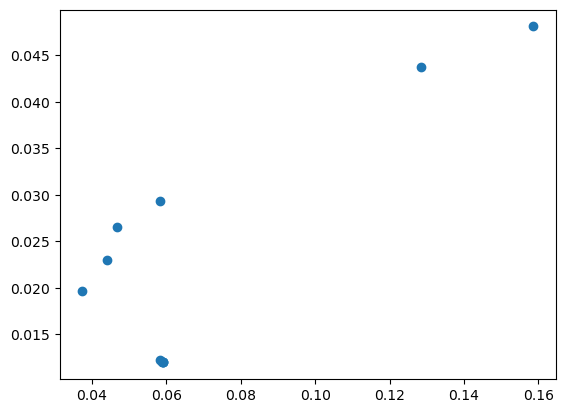

PyObject <matplotlib.collections.PathCollection object at 0x7f2daf0c1cd0>

In [353]:
plt.scatter(risks_GA, rets_GA)

# TO DO

- Compute MPT with both pct_change and log returns and plot and compare together
- Compute MPT unconstrained